In [2]:
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Dense, Activation, Lambda
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.merge import Concatenate
from config_reader import config_reader
import scipy
import math

Using TensorFlow backend.


In [3]:
def relu(x): 
    return Activation('relu')(x)

def conv(x, nf, ks, name):
    x1 = Conv2D(nf, (ks, ks), padding='same', name=name)(x)
    return x1

def pooling(x, ks, st, name):
    x = MaxPooling2D((ks, ks), strides=(st, st), name=name)(x)
    return x

def vgg_block(x):
     
    # Block 1
    x = conv(x, 64, 3, "conv1_1")
    x = relu(x)
    x = conv(x, 64, 3, "conv1_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool1_1")

    # Block 2
    x = conv(x, 128, 3, "conv2_1")
    x = relu(x)
    x = conv(x, 128, 3, "conv2_2")
    x = relu(x)
    x = pooling(x, 2, 2, "pool2_1")
    
    # Block 3
    x = conv(x, 256, 3, "conv3_1")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_2")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_3")
    x = relu(x)    
    x = conv(x, 256, 3, "conv3_4")
    x = relu(x)    
    x = pooling(x, 2, 2, "pool3_1")
    
    # Block 4
    x = conv(x, 512, 3, "conv4_1")
    x = relu(x)    
    x = conv(x, 512, 3, "conv4_2")
    x = relu(x)    
    
    # Additional non vgg layers
    x = conv(x, 256, 3, "conv4_3_CPM")
    x = relu(x)
    x = conv(x, 128, 3, "conv4_4_CPM")
    x = relu(x)
    
    return x

def stage1_block(x, num_p, branch):
    
    # Block 1        
    x = conv(x, 128, 3, "conv5_1_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_2_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 128, 3, "conv5_3_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, 512, 1, "conv5_4_CPM_L%d" % branch)
    x = relu(x)
    x = conv(x, num_p, 1, "conv5_5_CPM_L%d" % branch)
    
    return x

def stageT_block(x, num_p, stage, branch):
        
    # Block 1        
    x = conv(x, 128, 7, "Mconv1_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv2_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv3_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv4_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 7, "Mconv5_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, 128, 1, "Mconv6_stage%d_L%d" % (stage, branch))
    x = relu(x)
    x = conv(x, num_p, 1, "Mconv7_stage%d_L%d" % (stage, branch))
    
    return x

In [4]:

weights_path = "./keras_Realtime_Multi-Person_Pose_Estimation/model/keras/model.h5"

input_shape = (None,None,3)

img_input = Input(shape=input_shape)

stages = 6
np_branch1 = 38
np_branch2 = 19

img_normalized = Lambda(lambda x: x / 256 - 0.5)(img_input)  # [-0.5, 0.5]

# VGG
stage0_out = vgg_block(img_normalized)

# stage 1
stage1_branch1_out = stage1_block(stage0_out, np_branch1, 1)
stage1_branch2_out = stage1_block(stage0_out, np_branch2, 2)
x = Concatenate()([stage1_branch1_out, stage1_branch2_out, stage0_out])

# stage t >= 2
for sn in range(2, stages + 1):
    stageT_branch1_out = stageT_block(x, np_branch1, sn, 1)
    stageT_branch2_out = stageT_block(x, np_branch2, sn, 2)
    if (sn < stages):
        x = Concatenate()([stageT_branch1_out, stageT_branch2_out, stage0_out])

model = Model(img_input, [stageT_branch1_out, stageT_branch2_out])
model.load_weights(weights_path)

In [5]:
%matplotlib inline
import cv2
import matplotlib
import pylab as plt
import numpy as np
import util

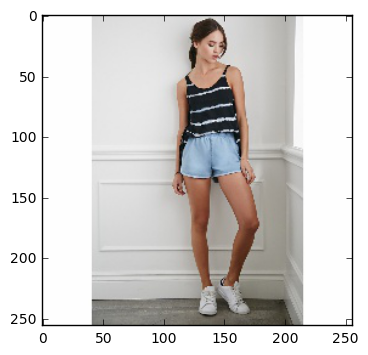

In [6]:
test_image = './keras_Realtime_Multi-Person_Pose_Estimation/sample_images/deepfashion.jpg'
oriImg = cv2.imread(test_image) # B,G,R order
plt.imshow(oriImg[:,:,[2,1,0]])

In [33]:
multiplier = [x * 368 / oriImg.shape[0] for x in (0.5, 1, 1.5, 2)]
print(multiplier)

[0.71875, 1.4375, 2.15625, 2.875]


In [8]:
from scipy.ndimage.filters import gaussian_filter

In [46]:
heatmap_avg = np.zeros((oriImg.shape[0], oriImg.shape[1], 19))
import time 
start = time.time()

# for m in range(len(multiplier)-4, len(multiplier)-3):
#     scale = multiplier[m]
#     imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
#     imageToTest_padded, pad = util.padRightDownCorner(imageToTest, 8, 128)        
#     axarr[m].imshow(imageToTest_padded[:,:,[2,1,0]])
#     axarr[m].set_title('Input image: scale %d' % m)

#     input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
#     print("Input shape: " + str(input_img.shape))  

#     output_blobs = model.predict(input_img)
#     print("Output shape (heatmap): " + str(output_blobs[1].shape))
    
#     # extract outputs, resize, and remove padding
#     heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
#     heatmap = cv2.resize(heatmap, (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
#     heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
#     heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)
scale = multiplier[0]
imageToTest = cv2.resize(oriImg, (0,0), fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
imageToTest_padded, pad = util.padRightDownCorner(imageToTest, 8, 128)        
input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
output_blobs = model.predict(input_img)
heatmap = np.squeeze(output_blobs[1]) # output 1 is heatmaps
heatmap = cv2.resize(heatmap, (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
heatmap = heatmap[:imageToTest_padded.shape[0]-pad[2], :imageToTest_padded.shape[1]-pad[3], :]
heatmap = cv2.resize(heatmap, (oriImg.shape[1], oriImg.shape[0]), interpolation=cv2.INTER_CUBIC)

heatmap_avg = heatmap_avg + heatmap #/ len(multiplier)
print('time spent: ', time.time() - start)

time spent:  3.2567310333251953


(256, 256, 19)
(256, 256)


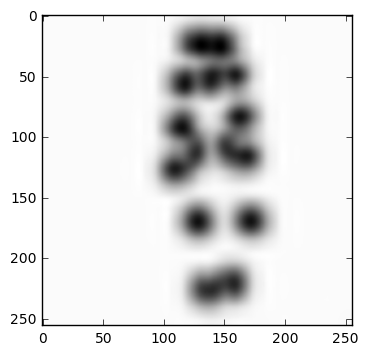

In [47]:
print(heatmap_avg.shape)
print(heatmap_avg[:,:,0].shape)
plt.imshow(heatmap_avg[:,:,18], cmap='gray')

In [48]:
from scipy.ndimage.filters import gaussian_filter
all_peaks = []
peak_counter = 0

for part in range(19-1):
    map_ori = heatmap_avg[:,:,part]
    map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > 0.1))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map_ori[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [49]:
print(all_peaks)
# print(len(all_peaks))
'''
with proper heatmap_avg
[[(144, 29, 0.89805662631988525, 0)], [(136, 53, 0.83784583210945129, 1)], [(117, 57, 0.77461537718772888, 2)], 
[(115, 94, 0.75420710444450378, 3)], [(111, 129, 0.80241388082504272, 4)], [(156, 49, 0.76093442738056183, 5)], 
[(164, 85, 0.81961597502231598, 6)], [(166, 117, 0.83532634377479553, 7)], [(127, 110, 0.50427039712667465, 8)], 
[(129, 169, 0.75576862692832947, 9)], [(136, 224, 0.6309247612953186, 10)], [(151, 109, 0.52144970372319221, 11)], 
[(171, 171, 0.81511923670768738, 12)], [(154, 220, 0.68123799562454224, 13)], [(139, 24, 0.90789347887039185, 14)], 
[(147, 24, 0.91656945645809174, 15)], [(127, 23, 0.89763996005058289, 16)], []]

only m = 0 time spent:  3.2155799865722656
[[(145, 29, 0.9330412745475769, 0)], [(137, 53, 0.94069427251815796, 1)], [(117, 56, 0.9354102611541748, 2)], [(115, 92, 0.95265638828277588, 3)], [(110, 127, 0.89857000112533569, 4)], [(157, 50, 0.923381507396698, 5)], [(163, 85, 0.92299234867095947, 6)], [(166, 116, 0.93874961137771606, 7)], [(126, 113, 0.84865337610244751, 8)], [(128, 170, 0.92739945650100708, 9)], [(136, 226, 0.8700789213180542, 10)], [(152, 110, 0.80442279577255249, 11)], [(171, 170, 0.91681671142578125, 12)], [(155, 221, 0.89798253774642944, 13)], [(139, 25, 0.97338736057281494, 14)], [(148, 25, 0.93902003765106201, 15)], [(127, 24, 0.9912257194519043, 16)], []]
only m = 1 time spent: 9.996121168136597
[[(144, 28, 0.93552333116531372, 0)], [(136, 53, 0.89965307712554932, 1)], [(117, 57, 0.84190481901168823, 2)], 
[(115, 94, 0.84269982576370239, 3)], [(111, 129, 0.86384302377700806, 4)], [(156, 49, 0.83049637079238892, 5)], 
[(164, 85, 0.8985438346862793, 6)], [(167, 118, 0.88154458999633789, 7)], [(126, 110, 0.62560451030731201, 8)],
[(129, 169, 0.81631910800933838, 9)], [(136, 224, 0.75649702548980713, 10)], [(151, 109, 0.63970047235488892, 11)], 
[(171, 171, 0.89010077714920044, 12)], [(154, 220, 0.82139259576797485, 13)], [(139, 24, 0.91629177331924438, 14)], 
[(147, 24, 0.98485362529754639, 15)], [(127, 24, 0.93173456192016602, 16)], []]

only m = 2 time spent:  21.994059085845947
[[(144, 29, 0.86732149124145508, 0)], [(136, 53, 0.81158089637756348, 1)], [(116, 57, 0.75433927774429321, 2)], 
[(115, 94, 0.70256215333938599, 3)], [(111, 128, 0.73501056432723999, 4)], [(156, 48, 0.71655386686325073, 5)], 
[(164, 86, 0.79481494426727295, 6)], [(166, 117, 0.81254130601882935, 7)], [(127, 110, 0.40394648909568787, 8)], 
[(129, 169, 0.71912026405334473, 9)], [(136, 225, 0.59503030776977539, 10)], [(151, 109, 0.40619954466819763, 11)], 
[(171, 171, 0.79731887578964233, 12)], [(154, 221, 0.59783989191055298, 13)], [(139, 24, 0.92830079793930054, 14)], 
[(147, 24, 0.91360229253768921, 15)], [(127, 23, 0.86297887563705444, 16)], []]

only m = 3
[[(144, 29, 0.85418814420700073, 0)], [(136, 53, 0.70566242933273315, 1)], [(117, 57, 0.57653027772903442, 2)], 
[(115, 95, 0.53999435901641846, 3)], [(111, 129, 0.7337644100189209, 4)], [(156, 48, 0.627083420753479, 5)], 
[(164, 85, 0.67507898807525635, 6)], [(166, 117, 0.7322160005569458, 7)], [(128, 105, 0.29449966549873352, 8)], 
[(130, 169, 0.60013371706008911, 9)], [(135, 221, 0.44994214177131653, 10)], [(151, 105, 0.30627012252807617, 11)], 
[(170, 171, 0.66244477033615112, 12)], [(155, 218, 0.46377894282341003, 13)], [(139, 24, 0.81711775064468384, 14)], 
[(147, 24, 0.84357285499572754, 15)], [(127, 23, 0.82447510957717896, 16)], []]
'''




[[(145, 29, 0.9330412745475769, 0)], [(137, 53, 0.94069427251815796, 1)], [(117, 56, 0.9354102611541748, 2)], [(115, 92, 0.95265638828277588, 3)], [(110, 127, 0.89857000112533569, 4)], [(157, 50, 0.923381507396698, 5)], [(163, 85, 0.92299234867095947, 6)], [(166, 116, 0.93874961137771606, 7)], [(126, 113, 0.84865337610244751, 8)], [(128, 170, 0.92739945650100708, 9)], [(136, 226, 0.8700789213180542, 10)], [(152, 110, 0.80442279577255249, 11)], [(171, 170, 0.91681671142578125, 12)], [(155, 221, 0.89798253774642944, 13)], [(139, 25, 0.97338736057281494, 14)], [(148, 25, 0.93902003765106201, 15)], [(127, 24, 0.9912257194519043, 16)], []]


'\nwith proper heatmap_avg\n[[(144, 29, 0.89805662631988525, 0)], [(136, 53, 0.83784583210945129, 1)], [(117, 57, 0.77461537718772888, 2)], \n[(115, 94, 0.75420710444450378, 3)], [(111, 129, 0.80241388082504272, 4)], [(156, 49, 0.76093442738056183, 5)], \n[(164, 85, 0.81961597502231598, 6)], [(166, 117, 0.83532634377479553, 7)], [(127, 110, 0.50427039712667465, 8)], \n[(129, 169, 0.75576862692832947, 9)], [(136, 224, 0.6309247612953186, 10)], [(151, 109, 0.52144970372319221, 11)], \n[(171, 171, 0.81511923670768738, 12)], [(154, 220, 0.68123799562454224, 13)], [(139, 24, 0.90789347887039185, 14)], \n[(147, 24, 0.91656945645809174, 15)], [(127, 23, 0.89763996005058289, 16)], []]\n\nonly m = 0 time spent:  3.2155799865722656\n[[(145, 29, 0.23326031863689423, 0)], [(137, 53, 0.23517356812953949, 1)], [(117, 56, 0.2338525652885437, 2)], \n[(115, 92, 0.23816409707069397, 3)], [(110, 127, 0.22464250028133392, 4)], [(157, 50, 0.2308453768491745, 5)], \n[(163, 85, 0.23074808716773987, 6)], [(16